In [ ]:
!pip install simpletransformers

In [ ]:
import numpy as np
import pandas as pd
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import label_ranking_average_precision_score, multilabel_confusion_matrix
import math
import matplotlib.pyplot as plt

Dictionaries to easily go from genre name to corresponding label index and vice-versa

In [ ]:
genreToIndex = {
    "Drama": 0,
    "Comedy": 1,
    "Thriller": 2,
    "Action": 3,
    "Romance": 4,
    "Adventure": 5,
    "Crime": 6,
    "Science Fiction": 7,
    "Horror": 8,
    "Family": 9,
    "Fantasy": 10,
    "Mystery": 11,
    "Animation": 12,
    "History": 13,
    "Music": 14,
    "War": 15,
    "Documentary": 16,
    "Western": 17,
    "Foreign": 18,
    "TV Movie": 19
}

indexToGenre = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "Adventure",
    "Crime",
    "Science Fiction",
    "Horror",
    "Family",
    "Fantasy",
    "Mystery",
    "Animation",
    "History",
    "Music",
    "War",
    "Documentary",
    "Western",
    "Foreign",
    "TV Movie"
]

### Load the dataset into a dataframe

In [ ]:
csv_path = '/content/drive/MyDrive/EDA/Project/data/tmdb.csv'

In [ ]:
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Helper functions for processing the data

Transform the genre column (each element is a list of genres) into a column where each element is a list of labels with binary values: 1 if the movie is associated with the genre at that index and 0 otherwise.

In [ ]:
def one_hot_encode_genres(df):
  labels = []
  for genres in df["genres"]:
    genreList = json.loads(genres)
    label = [0 for _ in range(len(indexToGenre))]
    for genre in genreList:
      genreName = genre["name"]
      genreIndex = genreToIndex[genreName]
      label[genreIndex] = 1
    labels.append(label)
  return labels

Extract the overview column (as a list) and replace NaN values with the empty string.

In [ ]:
def get_overviews(df):
  overviews = df["overview"].fillna("")
  return list(overviews)

Extract the title column (as a list) and replace NaN values with the empty string

In [ ]:
def get_titles(df):
  titles = df["title"].fillna("")
  return list(titles)

Extract the tagline column (as a list) and replace NaN values with the empty string

In [ ]:
def get_taglines(df):
  taglines = df["tagline"].fillna("")
  return list(taglines)

Extract the keywords column (as a list) and concatenate all keywords (separated by whitespace) for each example separately.

In [ ]:
def get_keywords_concat(df):
  keywordsAll = []
  for keywordsJson in df["keywords"]:
    keywordsList = json.loads(keywordsJson)
    keywords = []
    for keyword in keywordsList:
      keywordName = keyword["name"]
      keywords.append(keywordName)
    keywordsAll.append(" ".join(keywords))
  return keywordsAll

Build a dataframe from a list of lists (future columns) and a list of names (future column names).

In [ ]:
def get_dataframe(data_list, column_list):
  assert len(data_list) == len(column_list)

  newDf = pd.DataFrame()
  for i in range(len(data_list)):
    column = column_list[i]
    data = data_list[i]
    newDf[column] = data
    
  return newDf

### Make a new dataframe that will be fed to the model 

The dataframe has two columns. The first column contains the overview, title, tagline and keywords concatenated (separated by whitespace). The second column contains the list of binary values corresponding to the genres associated with the movie. This is the input format for the Transformer.

In [ ]:
overviews = get_overviews(df)
titles = get_titles(df)
taglines = get_taglines(df)
keywords = get_keywords_concat(df)
text = [ov + " " + ti + " " + ta + " " + ke for ov, ti, ta, ke in zip(overviews, titles, taglines, keywords)]
print(text[0])
print(text[1])

In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Avatar Enter the World of Pandora. culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d
Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems. Pirates of the Caribbean: At World's End At the end of the world, the adventure begins. ocean drug abuse exotic island east india trading company love of one's life traitor shipwreck strong woman ship alliance calypso afterlife fighter pirate swashbuckler aftercreditsstinger


In [ ]:
labels = one_hot_encode_genres(df)

newDf = get_dataframe(
    [text, labels],
    ["text", "labels"]
)
newDf.head()

,text,labels
0,"In the 22nd century, a paraplegic Marine is di...","[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
1,"Captain Barbossa, long believed to be dead, ha...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,A cryptic message from Bond’s past sends him o...,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Following the death of District Attorney Harve...,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"John Carter is a war-weary, former military ca...","[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
print(labels[:10])

[[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


### Train


Split the dataframe into a train and a test dataframe.

In [ ]:
train_df , test_df = train_test_split(newDf, test_size=0.2, random_state=6)

Define the transformer model.

In [ ]:
# Model configuration
model_args = MultiLabelClassificationArgs(num_train_epochs=10, train_batch_size=16)

In [ ]:
model  = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=len(indexToGenre), args=model_args)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight',

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Train the model on the train dataframe.

In [ ]:
model.train_model(train_df)

  0%|          | 0/3820 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/239 [00:00<?, ?it/s]

(2390, 0.15081900356953115)

### Inference

Evaluate the model on the test dataframe (and on the train dataframe just to check performance).

In [ ]:
def evaluate_model(model, df):
  result, model_outputs, _ = model.eval_model(df)
  print(result)
  return model_outputs

In [ ]:
# Evaluate model on test data
test_preds = evaluate_model(model, test_df)

  0%|          | 0/955 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/120 [00:00<?, ?it/s]

{'LRAP': 0.8433864727799663, 'eval_loss': 0.19149843659251928}


In [ ]:
# Evaluate model on train data
evaluate_model(model, train_df)

  0%|          | 0/3820 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/478 [00:00<?, ?it/s]

{'LRAP': 0.9882696929990576, 'eval_loss': 0.05768724553926096}


array([[9.67773438e-01, 2.28881836e-02, 2.81677246e-02, ...,
        1.09863281e-03, 2.30598450e-03, 5.07354736e-04],
       [2.29492188e-01, 1.03027344e-01, 3.94531250e-01, ...,
        1.39541626e-02, 6.90460205e-03, 1.88922882e-03],
       [9.49218750e-01, 9.64843750e-01, 5.75256348e-03, ...,
        4.62722778e-03, 1.04522705e-02, 4.41741943e-03],
       ...,
       [9.82910156e-01, 1.40609741e-02, 1.99432373e-02, ...,
        1.23023987e-03, 3.32450867e-03, 6.74724579e-04],
       [2.91442871e-02, 9.86328125e-01, 4.62951660e-02, ...,
        7.25936890e-03, 4.23049927e-03, 2.09045410e-03],
       [1.65863037e-02, 9.87792969e-01, 1.29241943e-02, ...,
        1.54304504e-03, 1.66130066e-03, 1.05285645e-03]])

In [ ]:
# Check some predictions
test_preds_rounded = np.rint(test_preds)
test_preds_rounded = test_preds_rounded.astype('i')
test_labels = np.array(list(test_df["labels"]))
for i in range(5):
  print(test_labels[i])
  print(test_preds_rounded[i])
  print()

[1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]

[1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



### Visualize how well the model performs

Display the confusion graph for each genre.

In [ ]:
def show_confusion_graph(y_true, y_pred):
  cols = 4
  conf_mat = multilabel_confusion_matrix(y_true, y_pred)
  genres_count = len(indexToGenre)
  figures_count = int(math.ceil(genres_count / cols))
  for figure_idx in range(figures_count):
    fig, axs = plt.subplots(1, cols, figsize=(16, 3))
    genre_idx = figure_idx * cols
    offset = 0
    while offset < cols and genre_idx + offset < genres_count:
      col = offset
      mat = conf_mat[genre_idx + offset]
      tn = mat[0, 0] # True Negatives
      fp = mat[0, 1] # False Positives
      fn = mat[1, 0] # False Negatives
      tp = mat[1, 1] # True Positives
      names = ["TP", "FP", "FN", "TN"]
      values = [tp, fp, fn, tn]
      axs[col].bar(names, values)
      axs[col].set_title(indexToGenre[genre_idx + offset])
      offset += 1
    plt.show()

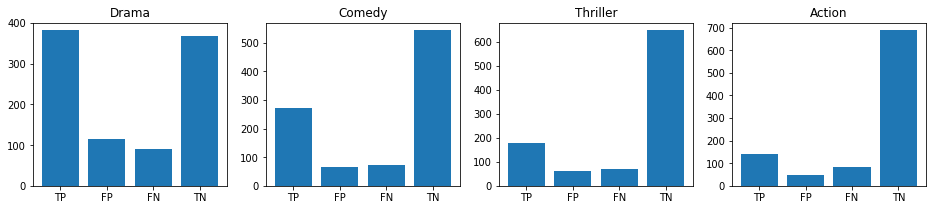

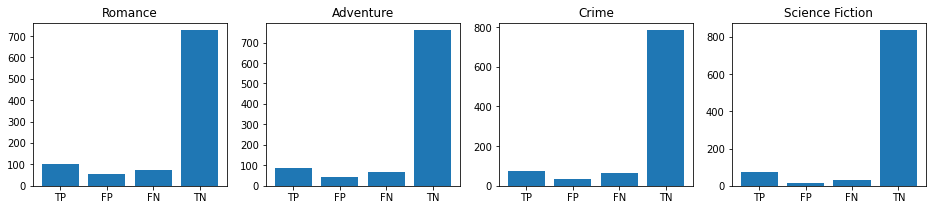

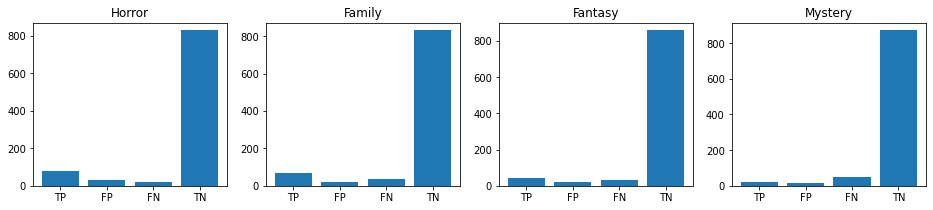

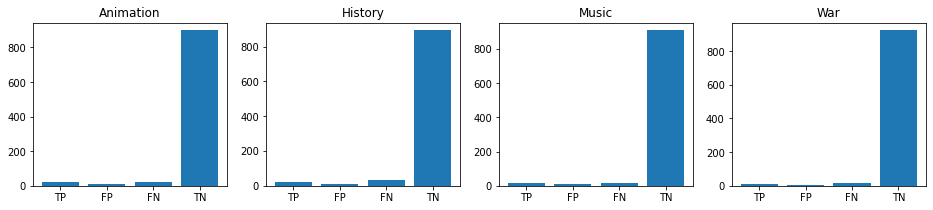

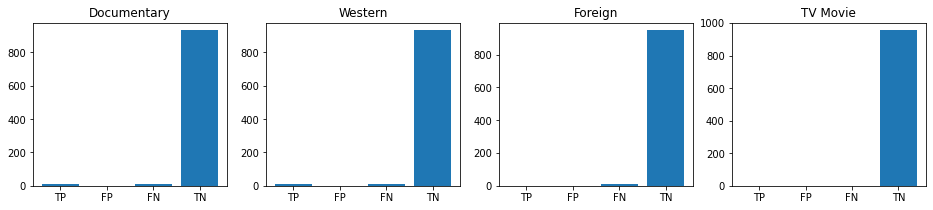

In [ ]:
show_confusion_graph(test_labels, test_preds_rounded)